In [77]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [104]:
import zipfile
import os

with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('path_to_extract_to')


In [105]:
import os
import shutil

train_path = '/content/path_to_extract_to/Training'
test_path = '/content/path_to_extract_to/Testing'


def remove_checkpoints(path):
    checkpoint_folder = os.path.join(path, '.ipynb_checkpoints')
    if os.path.exists(checkpoint_folder):
        shutil.rmtree(checkpoint_folder)
        print(f"Removed: {checkpoint_folder}")

remove_checkpoints(train_path)
remove_checkpoints(test_path)



In [112]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [113]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [114]:
class_labels = sorted(os.listdir(train_path))
class_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [115]:
from sklearn.utils.class_weight import compute_class_weight
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

train_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


In [116]:
from tensorflow.keras.applications.vgg16 import VGG16

base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base.layers:
    layer.trainable = False


base.layers[-2].trainable=True
base.layers[-3].trainable=True

In [117]:
base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [118]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(base)
model.add(Flatten())
model.add(Dropout(0.3))


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))


In [119]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 7,931,524 (30.26 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [120]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [121]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)

history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.5324 - loss: 1.3585

143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 565ms/step - accuracy: 0.5330 - loss: 1.3553 - val_accuracy: 0.6641 - val_loss: 0.8924
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 122s 439ms/step - accuracy: 0.7710 - loss: 0.5603 - val_accuracy: 0.6603 - val_loss: 0.8773
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8421 - loss: 0.4357

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 449ms/step - accuracy: 0.8422 - loss: 0.4355 - val_accuracy: 0.7595 - val_loss: 0.7514
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 447ms/step - accuracy: 0.8941 - loss: 0.3208 - val_accuracy: 0.7481 - val_loss: 0.7693
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 443ms/step - accuracy: 0.8977 - loss: 0.2936 - val_accuracy: 0.7099 - val_loss: 0.8347
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8992 - loss: 0.2775

143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 452ms/step - accuracy: 0.8992 - loss: 0.2775 - val_accuracy: 0.7824 - val_loss: 0.6160
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 453ms/step - accuracy: 0.9068 - loss: 0.2633 - val_accuracy: 0.7824 - val_loss: 0.5854
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9143 - loss: 0.2388

143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 448ms/step - accuracy: 0.9143 - loss: 0.2387 - val_accuracy: 0.8282 - val_loss: 0.4805
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9215 - loss: 0.2221

143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 453ms/step - accuracy: 0.9215 - loss: 0.2221 - val_accuracy: 0.8359 - val_loss: 0.5360
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 452ms/step - accuracy: 0.9398 - loss: 0.1680 - val_accuracy: 0.8168 - val_loss: 0.6356
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9318 - loss: 0.2015

143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 461ms/step - accuracy: 0.9318 - loss: 0.2016 - val_accuracy: 0.8473 - val_loss: 0.4651
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 445ms/step - accuracy: 0.9278 - loss: 0.2130 - val_accuracy: 0.8206 - val_loss: 0.6308
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 450ms/step - accuracy: 0.9273 - loss: 0.2069 - val_accuracy: 0.8321 - val_loss: 0.6156
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 453ms/step - accuracy: 0.9322 - loss: 0.1746 - val_accuracy: 0.8321 - val_loss: 0.7132


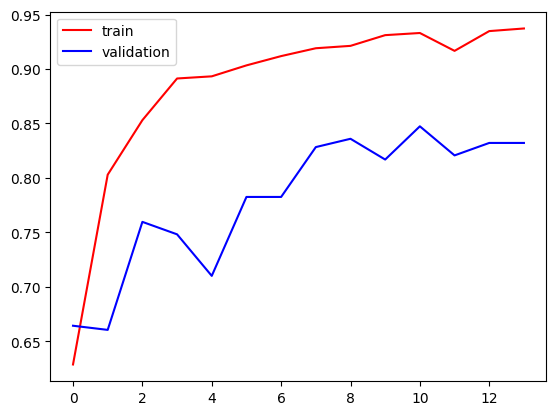

In [122]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

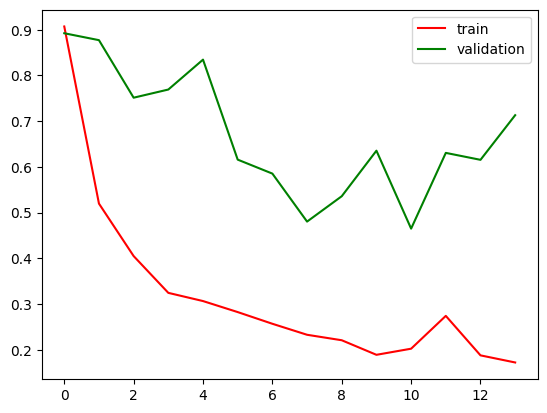

In [123]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='green',label='validation')
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score

In [124]:
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob,axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step


In [125]:
acc=accuracy_score(y_true,y_pred)
f1 = f1_score(y_true,y_pred,average='weighted')

In [126]:
print('accuracy: ',acc)

accuracy:  0.8816793893129771


In [127]:
print('f1_score: ',f1)

f1_score:  0.8830285563632859


In [128]:
target_names = list(val_generator.class_indices.keys())
print(classification_report(y_true,y_pred,target_names=target_names))

              precision    recall  f1-score   support

      glioma       0.83      0.90      0.86        60
  meningioma       0.78      0.80      0.79        61
     notumor       0.92      0.90      0.91        81
   pituitary       1.00      0.92      0.96        60

    accuracy                           0.88       262
   macro avg       0.88      0.88      0.88       262
weighted avg       0.89      0.88      0.88       262



In [129]:
val_generator.reset()
pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step


In [130]:
y_true = val_generator.classes


In [131]:
class_labels = list(val_generator.class_indices.keys())
class_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [132]:
# Get filenames used in validation
filenames = val_generator.filenames

# Show prediction vs true for first 10 samples
for i in range(10):
    print(f"File: {filenames[i]}")
    print(f"True: {class_labels[y_true[i]]} | Predicted: {class_labels[y_pred[i]]}\n")


File: glioma/Te-glTr_0000.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0001.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0002.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0003.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0004.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0005.jpg
True: glioma | Predicted: meningioma

File: glioma/Te-glTr_0006.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0007.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0008.jpg
True: glioma | Predicted: glioma

File: glioma/Te-glTr_0009.jpg
True: glioma | Predicted: glioma



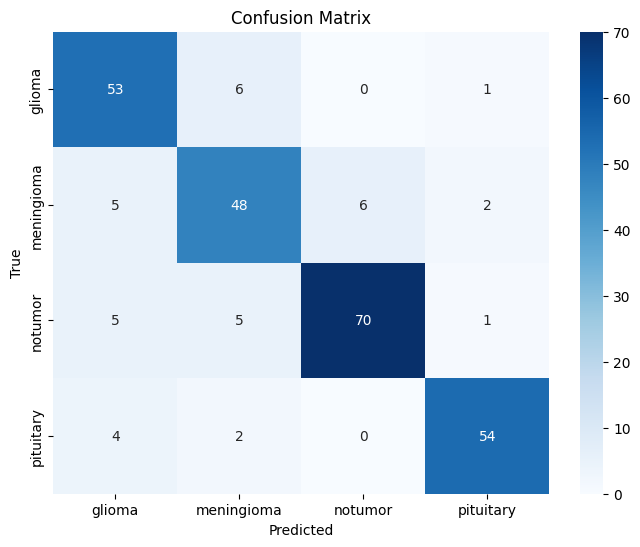

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

